# Face Detection Analysis

On this notebook the important elements to analyse are:
* **Detection time relative to frame rate and area:** The frame size and the total duration of the video impact on the time spent detecting. We can change the resolution but not the length of the video, instead we can change the frequency the detection happens.
* **Face area relative to frame scale and frame size threshold:** Changing the resolution of the video can impact on the number of faces we detect.
* **Content delta distribution to select threshold:** For the next stage of the pipeline a threshold is required for shot transitions.

In [1]:
DETECTION_PATH = r'\\Desktop-0331tte\d\chiletv-testdata\detection'
DETECTION_DATAFRAME = r'..\data\face_detection_testdata.h5'

In [2]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt

plt.style.use('classic')

%matplotlib inline

import seaborn as sns

sns.set()

In [4]:
def read_data(detection_path):
    loop = tqdm(list(Path(detection_path).glob(r'**/*.detections.json')))
    columns_as_is = [
        'frame_rate', 'batch_size', 'min_face_size', 'max_frame_size', 'width', 'height', 'video_length', 'detection_length']
    for file in loop:
        with file.open('r', encoding='utf8') as fp:
            try:
                obj = json.load(fp)
            except json.JSONDecodeError as err:
                loop.write('ERROR:', file)
                continue
                        
            row = {k:obj[k] for k in columns_as_is}
            row['video_id'] = file.name[:file.name.index('.')]
            row['frame_scale'] = obj.get('frame_scale', float(file.parent.name[1:file.parent.name.index('-')]))
            
            for time, content_delta, bboxes in zip(obj['time'], obj['content_delta'], obj['bounding_box']):
                row['time'] = time
                row['content_delta' ] = content_delta
                for bbox in bboxes:
                    row['bounding_box_width'] = bbox[2] - bbox[0]
                    row['bounding_box_height'] = bbox[3] - bbox[1]
                    yield row.copy()

dataframe_file = Path(DETECTION_DATAFRAME)
if not dataframe_file.exists():
    df = pd.DataFrame(read_data(DETECTION_PATH))
    df.to_hdf(dataframe_file, key='df', mode='w', complevel=9)  
else:
    df = pd.read_hdf(dataframe_file)

In [5]:
df.describe()

,frame_rate,batch_size,min_face_size,width,height,video_length,detection_length,frame_scale,time,content_delta,bounding_box_width,bounding_box_height
count,1.568148e+07,1.568148e+07,15681475.0,1.568148e+07,1.568148e+07,1.568148e+07,1.568148e+07,15681475.0,1.568148e+07,1.568148e+07,1.568148e+07,1.568148e+07
mean,2.292699e+01,1.356032e+02,20.0,1.381701e+03,7.914146e+02,1.729620e+03,5.625701e+03,1.0,8.623042e+02,2.231972e+01,1.196291e+02,1.601240e+02
std,9.399235e+00,1.647247e+02,0.0,4.833658e+02,2.515128e+02,9.689399e+02,5.473427e+03,0.0,7.386127e+02,2.165771e+01,9.620413e+01,1.305933e+02
min,3.000000e+00,3.200000e+01,20.0,3.200000e+02,2.400000e+02,3.325667e+02,4.298752e+01,1.0,3.333333e-02,0.000000e+00,6.728653e+00,9.349384e+00
25%,1.500000e+01,3.800000e+01,20.0,1.280000e+03,7.200000e+02,8.781000e+02,1.877003e+03,1.0,3.037333e+02,8.124038e+00,5.179260e+01,6.983679e+01
50%,3.000000e+01,9.400000e+01,20.0,1.280000e+03,7.200000e+02,1.483933e+03,3.784603e+03,1.0,6.405000e+02,1.509967e+01,9.242911e+01,1.219390e+02
75%,3.000000e+01,1.080000e+02,20.0,1.920000e+03,1.080000e+03,2.602467e+03,7.213997e+03,1.0,1.212533e+03,2.875761e+01,1.589174e+02,2.122514e+02
max,3.000000e+01,1.024000e+03,20.0,1.920000e+03,1.080000e+03,3.504700e+03,2.708097e+04,1.0,3.500200e+03,1.594804e+02,1.752827e+03,2.766937e+03


## Detection time relative to frame rate and area

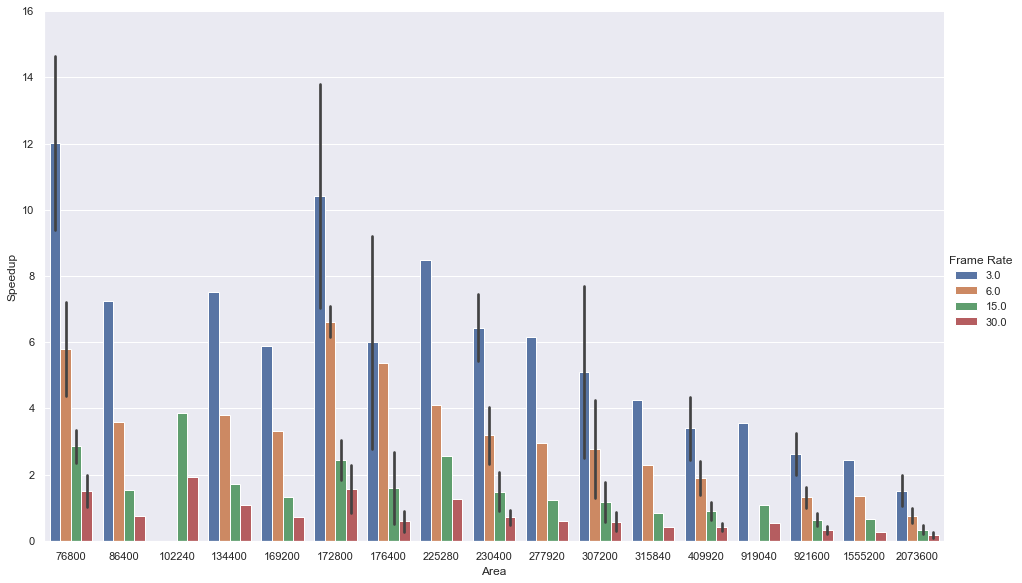

In [6]:
# Pick only test samples where frame_scale==1 and max_frame_size == None
_df = df.where(df['frame_scale']==1 & df['max_frame_size'].isna())

_df['area'] = _df['width'] * _df['height']
_df['speedup'] = _df['video_length'] / _df['detection_length']

g = sns.catplot(data=_df, kind='bar', x='area', y='speedup', hue='frame_rate', ci='sd', height=8.27, aspect=1.618)
g._legend.set_title('Frame Rate')
g.set(xlabel='Area', ylabel='Speedup')

plt.savefig('images/speedup_by_frame_rate.svg', bbox_inches='tight')
plt.savefig('images/speedup_by_frame_rate.png', bbox_inches='tight')

**Figure \[speedup_by_frame_rate]:** A decrease in the frame rate does improve the time spent detecting faces. The bin which would contain the videos with a resolution of 550x550 is highlithed.

## Face area relative to frame scale and frame size threshold

In [7]:
# Pick only test samples where frame_rate==3 and max_frame_size == None
_df = df.where((df['frame_rate']==3 & df['max_frame_size'].isna()))
_df.head()

,frame_rate,batch_size,min_face_size,max_frame_size,width,height,video_length,detection_length,video_id,frame_scale,time,content_delta,bounding_box_width,bounding_box_height
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Pick only test samples where frame_rate==3 and frame_scale == 1
_df = df.where((df['frame_rate']==3) & (df['frame_scale']==1))
_df.head()

,frame_rate,batch_size,min_face_size,max_frame_size,width,height,video_length,detection_length,video_id,frame_scale,time,content_delta,bounding_box_width,bounding_box_height
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Content delta distribution to select threshold